In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import zipfile
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import keras

Using TensorFlow backend.


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls ../content/drive/My\ Drive

In [0]:
data_root = "../content/drive/My Drive/"

In [0]:
fantasy_zip = zipfile.ZipFile(os.path.join(data_root, 'plates.zip'))
fantasy_zip.extractall('../content/')

In [0]:
data_root = "../content/drive/My Drive/data/plates"

In [0]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:05<00:00,  3.33it/s]


In [8]:
!ls ../content/plates/train

cleaned  dirty


In [0]:
#Import the Inception model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [10]:
CLASSES = 2
img_size = 224
base_model = InceptionV3(include_top = False, #leave out the last fully connected layer
                         weights = 'imagenet', input_shape=(img_size, img_size, 3))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
87916544/87910968 [==============================] - 3s 0us/step


In [0]:
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Dense, Flatten
from tensorflow.keras import Model
from tensorflow.keras import optimizers
base_model.trainable = False
x = base_model.output
x = Flatten()(x)
x = Dense(4096, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="softmax")(x)
model = Model(inputs = base_model.input, outputs = predictions)

model.compile(loss='binary_crossentropy', optimizer = 'rmsprop',
              metrics=['accuracy'])


In [12]:
!ls ../content/plates/train/dirty

0000.jpg  0003.jpg  0006.jpg  0009.jpg	0012.jpg  0015.jpg  0018.jpg
0001.jpg  0004.jpg  0007.jpg  0010.jpg	0013.jpg  0016.jpg  0019.jpg
0002.jpg  0005.jpg  0008.jpg  0011.jpg	0014.jpg  0017.jpg


In [28]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input

WIDTH = 224
HEIGHT = 224
BATCH_SIZE = 8
TRAIN_DIR = '../content/plates/train'
TEST_DIR = '../content/plates/'
#VAL_DIR = '../content/val'
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,   
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(HEIGHT, WIDTH),
		batch_size=BATCH_SIZE,
    shuffle=True,
		class_mode='binary')

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_generator = test_datagen.flow_from_directory(     
        TEST_DIR,
        classes=['test'],
        target_size = (HEIGHT, WIDTH),
        batch_size = 1,  
        shuffle = False,     
        class_mode = None) 

Found 40 images belonging to 2 classes.
Found 744 images belonging to 1 classes.


In [14]:
from matplotlib import pyplot
imga = next(test_generator)
print(imga.shape)

(1, 224, 224, 3)


"\nx_batch = next(test_generator)\n#print(x_batch.shape)\nplt.figure(figsize=(12, 9))\n\nfor k, img in enumerate(x_batch):\n    plt.subplot(2, 4, k+1)\n    plt.imshow((img[k]+1)/2)\n    plt.axis('off')\n"

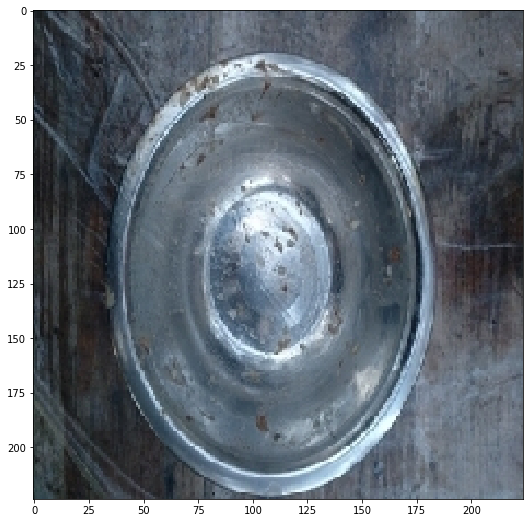

In [15]:
from matplotlib import pyplot
imga = next(test_generator)
plt.figure(figsize=(12, 9))
plt.subplot(1,1,1)
plt.imshow((imga[0]+1)/2)

'''
x_batch = next(test_generator)
#print(x_batch.shape)
plt.figure(figsize=(12, 9))

for k, img in enumerate(x_batch):
    plt.subplot(2, 4, k+1)
    plt.imshow((img[k]+1)/2)
    plt.axis('off')
'''


In [0]:
img[0].shape

(224, 3)

(8, 224, 224, 3)


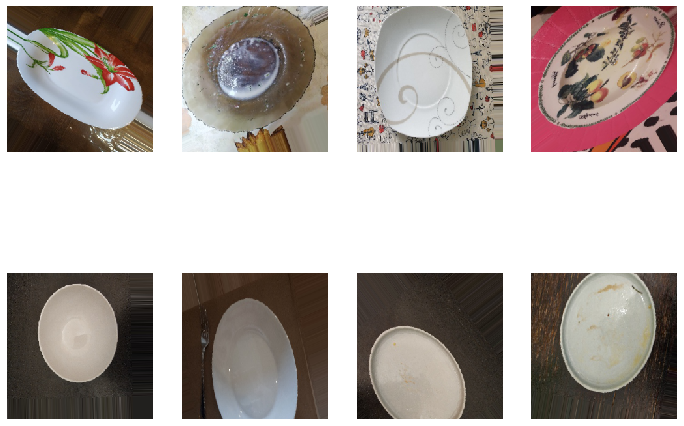

In [29]:
import torch
#plot some images result from data augmentation
x_batch1, y_batch1 = next(train_generator)
print(x_batch1.shape)
plt.figure(figsize=(12, 9))
for k, (img, lbl) in enumerate(zip(x_batch1, y_batch1)):
    plt.subplot(2, 4, k+1)
    plt.imshow((img+1)/2)
    plt.axis('off')

In [0]:
model.summary()

In [30]:
# import fit_generator
EPOCHS = 20
BATCH_SIZE = 8
STEPS_PER_EPOCH = 50
#VALIDATION_STEPS = 8
MODEL_FILE = 'filename.h5'
history = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    #validation_data=validation_generator,
    #validation_steps=VALIDATION_STEPS
    )
#model.save(MODEL_FILE)

Epoch 1/20
17/50 [=========>....................] - ETA: 1:50 - loss: 7.7794 - acc: 0.4926

KeyboardInterrupt: ignored

In [0]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=EPOCHS,
        verbose=1)

In [0]:
test_generator.reset()
predict = model.predict_generator(test_generator, steps = len(test_generator.filenames))
len(predict)

744

In [0]:
predict

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [0]:
from pandas import DataFrame
test_generator.reset()
predict = model.predict_generator(test_generator, steps = len(test_generator.filenames))
d = {'id': [n for n in range(len(predict))], 
     'label': ['dirty' if x[0] > x[1] else 'cleaned' for x in predict]}
result_df = DataFrame(data=d)
print(result_df['label'].value_counts())
result_df.to_csv('Br_kaggle_sub.csv', index=False)

IndexError: ignored

In [0]:
predict

array([[1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 3.5827702e-34],
       ...,
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00]], dtype=float32)

In [0]:
sub_df = pd.read_csv('../content/sample_submission.csv')
sub_df.head()

FileNotFoundError: ignored

In [0]:

sub_df['label'] = predict
sub_df['label'] = sub_df['label'].apply(lambda x: 'dirty' if x > 0.5 else 'cleaned')
sub_df.head()

,id,label
0,0,dirty
1,1,dirty
2,2,dirty
3,3,dirty
4,4,dirty


In [0]:
sub_df['label'].value_counts()

dirty      743
cleaned      1
Name: label, dtype: int64

In [0]:
!apt-get install fi